In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
  #change directory
  %cd /content/drive/MyDrive/Math_6397/pics 

/content/drive/MyDrive/Math_6397/pics


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
from skimage.transform import resize
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

X = scipy.io.loadmat(os.path.join('..','DATA','VORTALL.mat'))
data=X['VORTALL']
a = 199 #width 
b = 449 #height

In [21]:
# coarsen library
n=data.shape[1]
clib=[]
lib=np.zeros((230,n))

for i in range(n):
  v= np.reshape(np.copy(data[:,i]),(b,a))
  coarse=resize(v,(23,10),anti_aliasing=True)
  clib=np.reshape(coarse,(230)).T
  lib[:,i]=clib

#lib=np.reshape(lib,(250,151))

In [5]:
def plotFlow(X,b,a):    
    ## Plot Mode 2
    vortmin = -5
    vortmax = 5
    V2 = np.copy(np.real(np.reshape(X,(b,a))))
    V2 = V2.T

    # normalize values... not symmetric
    minval = np.min(V2)
    maxval = np.max(V2)

    if np.abs(minval) < 5 and np.abs(maxval) < 5:
        if np.abs(minval) > np.abs(maxval):
            vortmax = maxval
            vortmin = -maxval
        else:
            vortmin = minval
            vortmax = -minval

    V2[V2 > vortmax] = vortmax
    V2[V2 < vortmin] = vortmin

    plt.imshow(V2,cmap='jet',vmin=vortmin,vmax=vortmax)

    cvals = np.array([-4,-2,-1,-0.5,-0.25,-0.155])
    plt.contour(V2,cvals*vortmax/5,colors='k',linestyles='dashed',linewidths=1)
    plt.contour(V2,np.flip(-cvals)*vortmax/5,colors='k',linestyles='solid',linewidths=0.4)

    plt.scatter(49*b/449,99*a/199,5000,color='k') # draw cylinder

    #plt.show()

In [6]:
import imageio
import os
from PIL import Image,ImageDraw
import glob

def createMovie(X,b,a):
  plt.rcParams['figure.figsize'] = [8, 8]
  filenames = []
  for i in range(150):
    plotFlow(X[:,i],b,a)
    filename = 'full'+str(i)
    filenames.append(filename)
    #fp=open ('full'+str(i)+'png','x')
    plt.savefig('full'+str(i))
    plt.close()
    #fp.close()
    
  fp_in = "full*.png"
  fp_out = "vortices.gif"
  
  img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
  img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True)
  
  removing = glob.glob('full*.png')
  for filename in removing:
    os.remove(filename)

In [10]:
#movie of original flow field
createMovie(data,449,199)

from IPython.display import Image as im
im(open('vortices.gif','rb').read())

Output hidden; open in https://colab.research.google.com to view.

In [22]:
#movie of flow field in new coordinates
createMovie(lib,23,10)
from IPython.display import Image as im
im(open('vortices.gif','rb').read())

Output hidden; open in https://colab.research.google.com to view.

In [27]:
#normalize columns of downsample library
nlib=np.zeros(n)
for k in range(n):
  nlib[k]=np.linalg.norm(lib[:,k])
  dlib=lib[:,k]/nlib[k]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


Text(0.5, 1.0, 'Reconstruct estimated fluid flow of column=104')

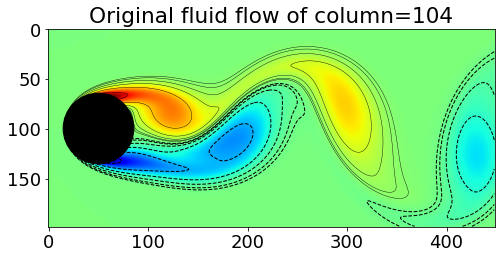

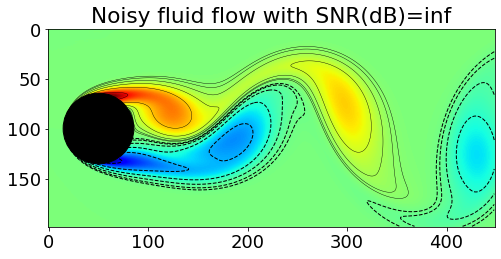

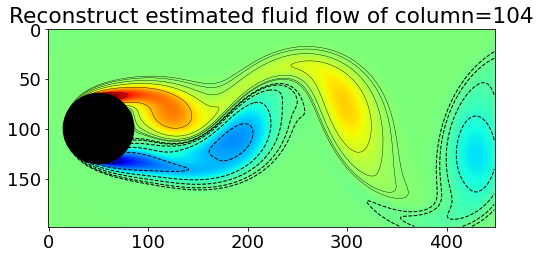

In [39]:
#pick a column of full field, downsample and estimate reconstructed flow field
#no noise
from random import *
import statistics
import pandas as pd
import math
from scipy.optimize import minimize

cp=randint(0,150)
data1=data[:,cp]
noise=0*np.random.randn(data1.shape[0])
datan=data1+noise
snr1=math.log(np.mean(data1**2/noise**2));

c2=[]
lib2=[]
std=[]

v2=np.reshape(datan,(b,a)) #noisy flow fuild
coarse2=resize(v2,(23,10),anti_aliasing=True)
c2=np.reshape(coarse2,(230)).T

def L1_norm(x):
    return np.linalg.norm(x,ord=1)
    
constr = ({'type': 'ineq', 'fun': lambda x: np.linalg.norm(lib @ x - c2,ord=2)})
x0 = np.linalg.pinv(lib) @ c2 # initialize with L2 solution
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s1 = res.x

id=pd.Series(s1).idxmax()

vr= np.copy(np.real(np.reshape(data[:,id],(b,a))))  #reconstructed flow field
v0=np.copy(np.real(np.reshape(data1,(b,a))))  #original flow fluid

plt.figure()
plotFlow(v0,449,199)
plt.title('Original fluid flow of column='+str(cp))
plt.figure()
plotFlow(v2,449,199)
plt.title('Noisy fluid flow with SNR(dB)='+str(snr1))
plt.figure()
plotFlow(vr,449,199)
plt.title('Reconstruct estimated fluid flow of column='+str(id))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


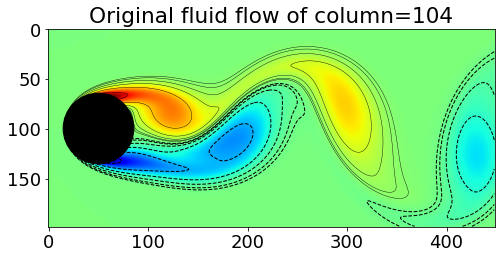

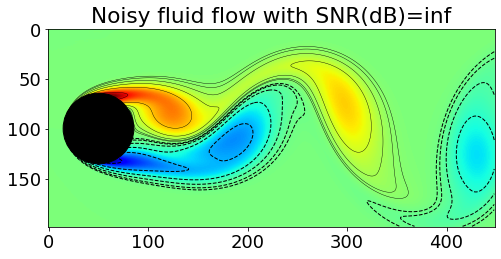

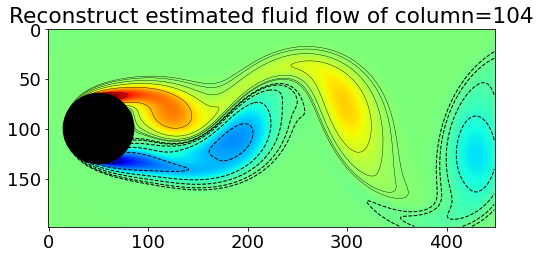

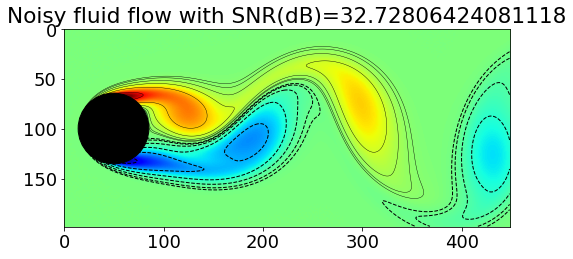

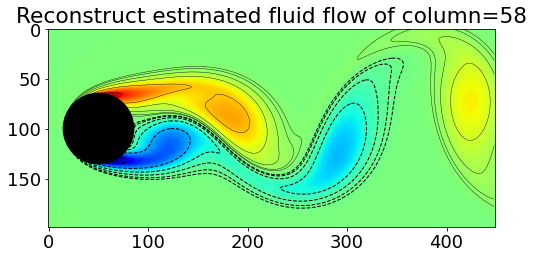

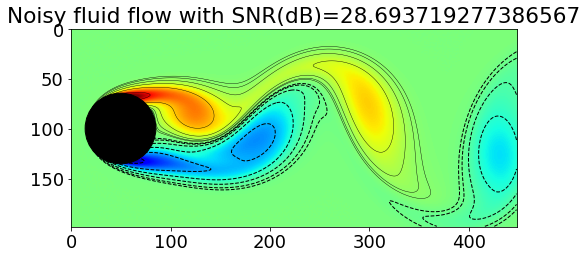

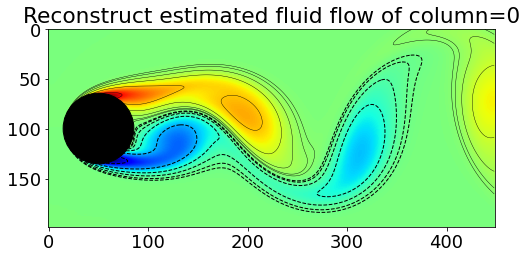

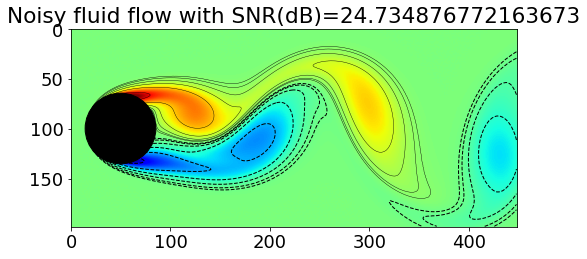

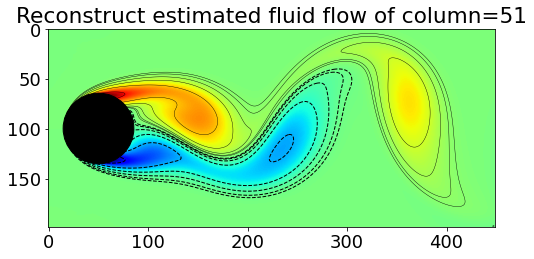

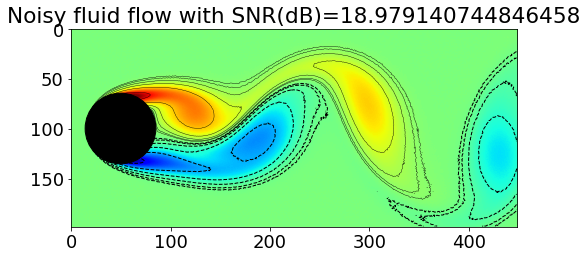

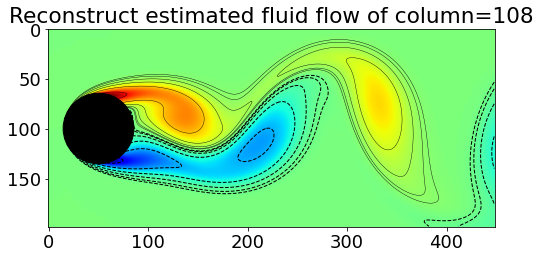

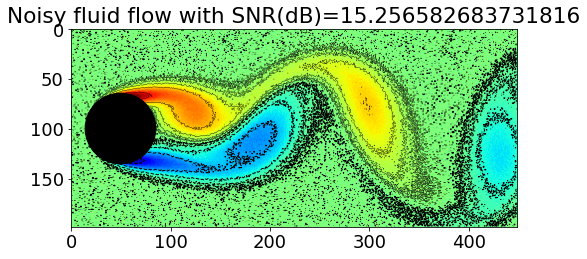

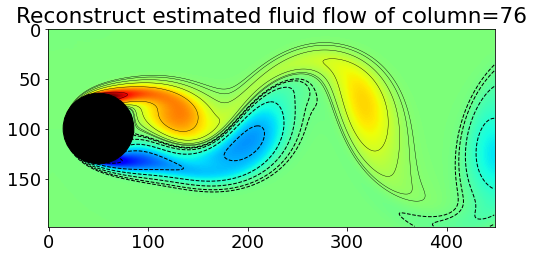

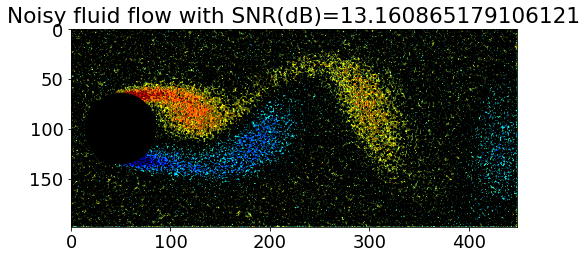

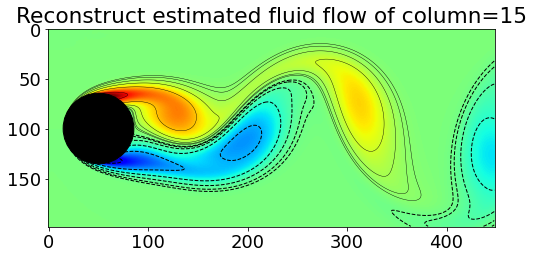

In [45]:
#with different noise
plt.figure()
plotFlow(v0,449,199)
plt.title('Original fluid flow of column='+str(cp))


for k in [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]:
  noise=np.random.randn(data1.shape[0])
  datan=data1+k*noise
  snr1=math.log(np.mean(data1**2/(k*noise)**2));
  c2=[]
  lib2=[]
  avg=[]
  
  v2=np.reshape(datan,(b,a)) #noisy flow fuild
  coarse2=resize(v2,(23,10),anti_aliasing=True)
  c2=np.reshape(coarse2,(230)).T
  
  def L1_norm(x):
    return np.linalg.norm(x,ord=1)
    
  constr = ({'type': 'ineq', 'fun': lambda x: np.linalg.norm(lib @ x - c2,ord=2)})
  x0 = np.linalg.pinv(lib) @ c2 # initialize with L2 solution
  res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
  s1 = res.x
  
  id=pd.Series(s1).idxmax()

  vr= np.copy(np.real(np.reshape(data[:,id],(b,a))))  #reconstructed flow field
  
  plt.figure()
  plotFlow(v2,449,199)
  plt.title('Noisy fluid flow with SNR(dB)='+str(snr1))
  plt.figure()
  plotFlow(vr,449,199)
  plt.title('Reconstruct estimated fluid flow of column='+str(id))


Here, the added noise amount is shown as SNR. When there is no noise then the correct reconstruction is estimated. As some noise are added the reconstruction become incorrect. But with decrease in SNR from 18dB to 15dB the estimated fluid flow even though not the exact one as before adding the noise but the flow is very similar to the original one.